In [ ]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
import requests
import numpy as np
import json
import ipywidgets as ipw
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_json('data_toolset/local_data.json')
ids = df['id'].unique()
print(ids)
df.columns

[100005525 300033641 100056983 100007115 100018089 100019265 300028856
 300027449 300023463 300038237 100007116 100005524 100037866 100033301
 100007117 100005527 100057696 300033642 100048215 300035391 300037150
 100033302 100018293 100018294 100033300 300033014 300035379 300035455
 100057697]


Index(['id', 'date', 'counts', 'status', 'name', 'user_type', 'photourl',
       'date_j'],
      dtype='object')

['2024-03-08' '2024-03-07' '2024-03-06' '2024-03-05' '2024-03-04'
 '2024-03-03' '2024-03-02' '2024-03-01' '2024-02-29' '2024-02-28'
 '2024-02-27' '2024-02-26' '2024-02-25' '2024-02-24' '2024-02-23'
 '2024-02-22' '2024-02-21' '2024-02-20' '2024-02-19' '2024-02-18'
 '2024-02-13' '2024-02-12' '2024-02-11' '2024-02-10' '2024-02-09'
 '2024-02-08' '2024-02-07' '2024-02-06' '2024-02-05' '2024-02-04'
 '2024-02-03' '2024-02-02' '2024-02-01' '2024-01-31' '2024-01-30'
 '2024-01-29' '2024-01-28' '2024-01-27' '2024-01-26' '2024-01-25'
 '2024-01-24' '2024-01-23' '2024-01-22' '2024-01-21' '2024-01-20'
 '2024-01-19' '2024-01-18' '2024-01-17' '2024-01-16' '2024-01-15'
 '2024-01-14' '2024-01-13' '2024-01-12' '2024-01-11' '2024-01-10'
 '2024-01-09' '2024-01-08' '2024-01-07' '2024-01-06' '2024-01-05'
 '2024-01-04' '2024-01-03' '2024-01-02' '2024-01-01' '2023-12-31'
 '2023-12-30' '2023-12-29' '2023-12-28' '2023-12-27' '2023-12-26'
 '2023-12-25' '2023-12-24' '2023-12-23' '2023-12-22' '2023-12-21'
 '2023-12-

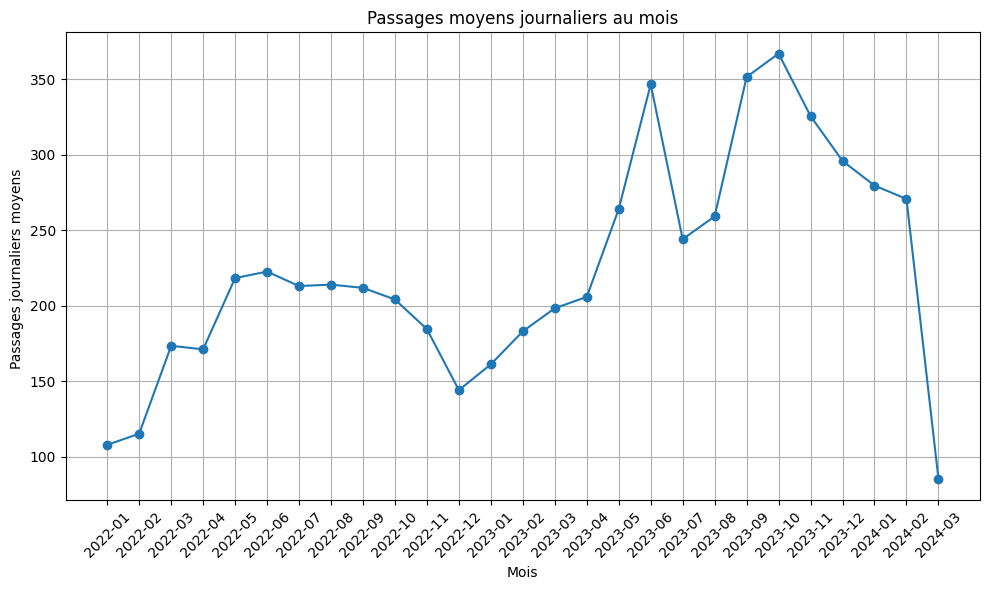

In [7]:
mois = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
an = ['2022', '2023', '2024']
date_jour = df['date_j'].unique()
print(date_jour)
# Convertir en datetime
df['date'] =  pd.to_datetime(df['date'], utc=True) # convertir depuis string en datetime
df['date_j'] = pd.to_datetime(df['date_j']) # convertir depuis string en datetime
df['month_year'] = df['date_j'].dt.to_period('M') # créer une colonne contenant le mois et l'année


# Créer une liste de tous les mois de 2022 à 2024
months = pd.period_range(start=df['month_year'].iloc[-1], end=df['month_year'].iloc[0], freq='M')

# Créer un DataFrame avec une colonne 'mois' contenant tous les mois et une colonne 'mean_count_per_day' initialisée à None
df_result = pd.DataFrame({'mois': months, 'mean_count_per_day': [None] * len(months)})

# Remplir la colonne 'mean_count_per_day' avec les valeurs moyennes correspondantes
for i, month_period in enumerate(months):
    # Calculer la valeur moyenne pour le mois donné
    total_counts = df[df['month_year'] == month_period]['counts'].sum()
    # passages moyennes journaliers par station
    mean_counts_per_day = total_counts / month_period.to_timestamp().days_in_month / len(df['name'].unique())
    # Assigner la valeur moyenne à la ligne correspondante dans le DataFrame résultant
    df_result.at[i, 'mean_count_per_day'] = mean_counts_per_day

# Afficher le résultat
plt.figure(figsize=(10, 6))
df_result['mois_str'] = df_result['mois'].astype(str)
plt.plot(df_result['mois_str'], df_result['mean_count_per_day'], marker='o', linestyle='-')

plt.title('Passages moyens journaliers au mois')
plt.xlabel('Mois')
plt.ylabel('Passages journaliers moyens ')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

           day      hour mean_count_per_day
0       Monday  00:00:00                  1
1      Tuesday  01:00:00                  0
2    Wednesday  02:00:00                  1
3     Thursday  03:00:00                  2
4       Friday  04:00:00                  3
..         ...       ...                ...
163  Wednesday  19:00:00                 13
164   Thursday  20:00:00                  9
165     Friday  21:00:00                  7
166   Saturday  22:00:00                  4
167     Sunday  23:00:00                  3

[168 rows x 3 columns]


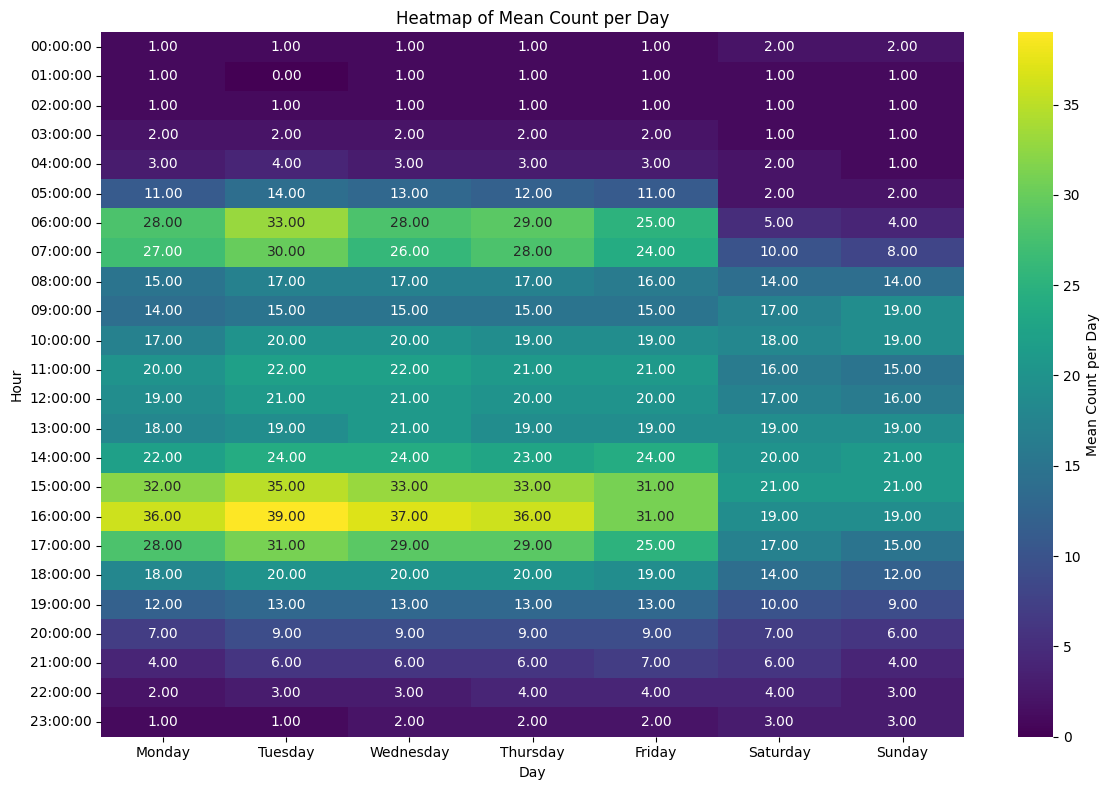

In [8]:
# Créer une liste de tous les heures dans une journée
heures = pd.period_range(start='00:00', end='23:00', freq='h')
heures_only = [str(heure.strftime('%H:%M:%S')) for heure in heures]

# Créer une liste de tous les jours de la semaine
days_in_a_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Créer un DataFrame avec une colonne 'day' contenant les jours, une colonne 'hour' contenant les heures, 
# et une colonne 'mean_count_per_day' initialisée à None
df_result = pd.DataFrame({'day': days_in_a_week * len(heures_only), # 24 heures x 7 jours
                          'hour': heures_only * len(days_in_a_week), 
                          'mean_count_per_day': [None] * len(days_in_a_week) * len(heures_only)})

df['day_name'] = df['date_j'].dt.day_name() # convertir depuis date en day_name (Monday, Tuesday)

# Extraire uniquement l'heure de la colonne 'date' et stocker le résultat dans une nouvelle colonne 'heure' dans df
df['heure'] = df['date'].dt.strftime('%H:%M:%S')

# Remplir la colonne 'mean_count_per_day' de df_result avec les valeurs moyennes appropriées
for hour in heures_only:
    for day_name in days_in_a_week:
        # créer un autre datafame qui contient toutes les données correspondantes au jour et à l'heure donnés
        filtered_data = df[(df['day_name'] == day_name) & (df['heure'] == hour)]
        # Calculer la moyenne des valeurs de la colonne 'counts' pour ces données filtrées
        mean_count = filtered_data['counts'].mean()
        # Assigner la valeur moyenne à la date et heure correspondantes dans le DataFrame résultant
        df_result.loc[(df_result['day'] == day_name) & (df_result['hour'] == hour), 'mean_count_per_day'] = round(mean_count)

print(df_result)

# Convertir les colonnes 'day' et 'hour' en variables catégorielles avec un ordre spécifique
df_result['day'] = pd.Categorical(df_result['day'], categories=days_in_a_week, ordered=True)
df_result['hour'] = pd.Categorical(df_result['hour'], categories=heures_only, ordered=True)
df_result['mean_count_per_day'] = pd.to_numeric(df_result['mean_count_per_day'], errors='coerce')

# Pivoter les données pour avoir les jours comme index, les heures comme colonnes et les valeurs de 'mean_count_per_day' comme valeurs
heatmap_data = df_result.pivot(index='hour', columns='day', values='mean_count_per_day')

# Tracer le heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Count per Day'})
plt.title('Heatmap of Mean Count per Day')
plt.xlabel('Day')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()

  jours_de_semaine moy_journaliere
0           Monday             241
1          Tuesday             270
2        Wednesday             260
3         Thursday             258
4           Friday             246
5         Saturday             175
6           Sunday             166


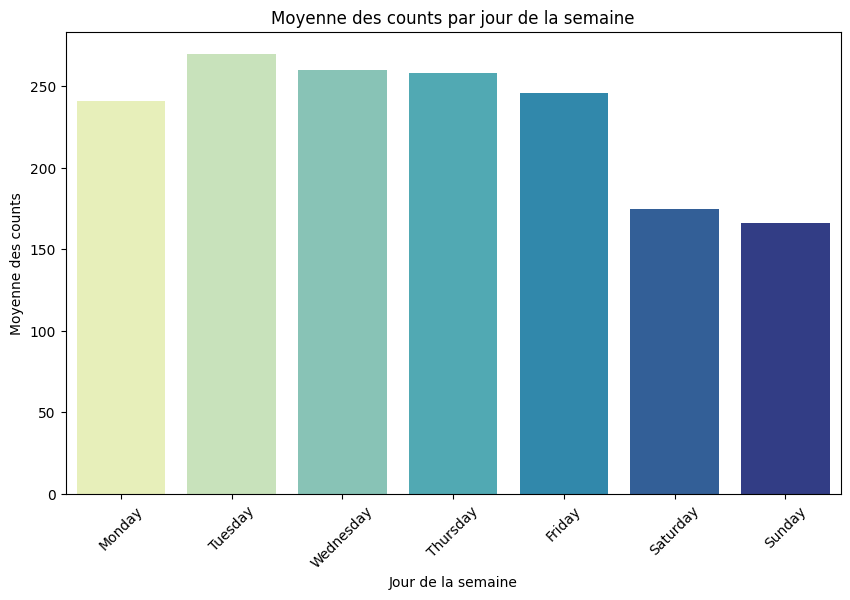

In [9]:
# Créer le DataFrame df_result_moy_journaliere
df_result_moy_journaliere = pd.DataFrame({'jours_de_semaine': days_in_a_week, 'moy_journaliere': [None] * len(days_in_a_week)})

# Pour chaque jour de la semaine
for day_name in days_in_a_week:
    # Filtrer les données pour le jour donné
    filtered_data = df[df['day_name'] == day_name]
    unique_days = len(filtered_data['date_j'].unique()) # enlever les heures et garder que la date
    # Calculer la moyenne des valeurs de la colonne 'counts' pour ces données filtrées
    mean_count = filtered_data['counts'].sum() / unique_days/ len(df['name'].unique())  # somme de tous les passages pour chaque date/ nombre de chaque date/ nombre de stations
    # Assigner la valeur moyenne à la date correspondante dans le DataFrame résultant
    df_result_moy_journaliere.loc[df_result_moy_journaliere['jours_de_semaine'] == day_name, 'moy_journaliere'] = round(mean_count)

print(df_result_moy_journaliere)

# Tracer un histogramme de la moyenne journalière
plt.figure(figsize=(10, 6))
sns.barplot(data=df_result_moy_journaliere, x='jours_de_semaine', y='moy_journaliere', hue='jours_de_semaine', palette='YlGnBu', dodge=False)
plt.title('Moyenne des counts par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Moyenne des counts')
plt.xticks(rotation=45)  # Rotation des étiquettes d'axe x pour une meilleure lisibilité
plt.show()


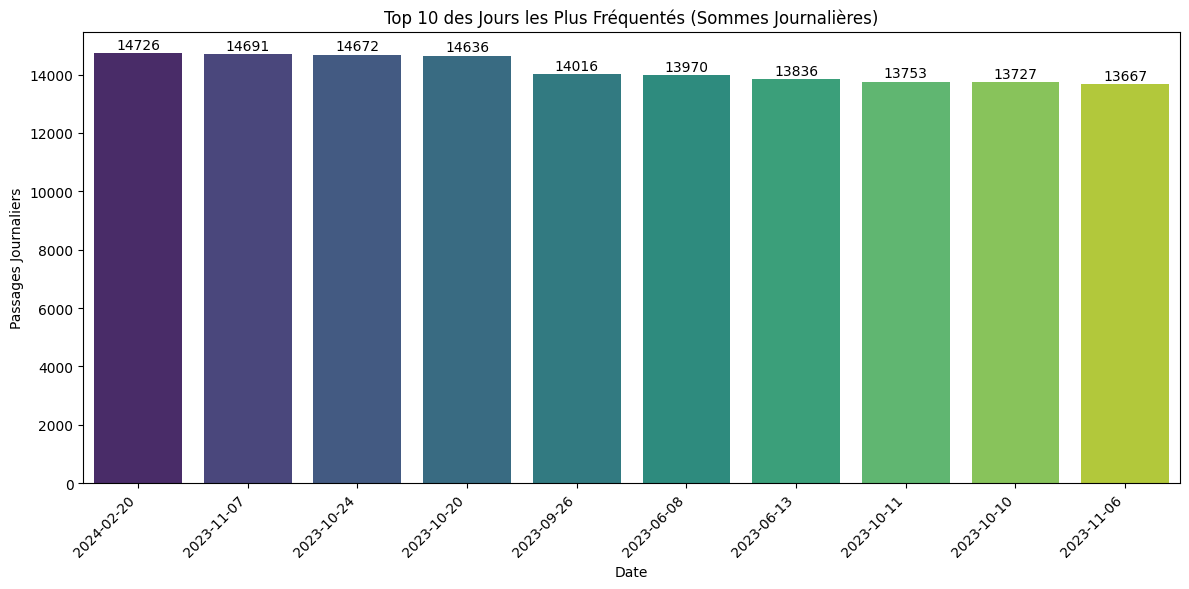

In [10]:
# Grouper par date_j et calculer la somme des passages pour chaque jour
daily_counts = df.groupby('date_j')['counts'].sum().reset_index()

# Trier par ordre décroissant pour obtenir les jours les plus fréquentés en premier
top_10_days = daily_counts.sort_values(by='counts', ascending=False).head(10)

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='date_j', y='counts', hue='date_j', data=top_10_days, palette='viridis', dodge=False, legend=False)
plt.title('Top 10 des Jours les Plus Fréquentés (Sommes Journalières)')
plt.xlabel('Date')
plt.ylabel('Passages Journaliers')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes d'axe x pour une meilleure lisibilité
plt.tight_layout()

# Afficher le nombre de passages sur chaque bar
for idx, value in enumerate(top_10_days['counts']):
    bar_plot.text(idx, value + 50, str(value), ha='center', va='bottom')

plt.show()

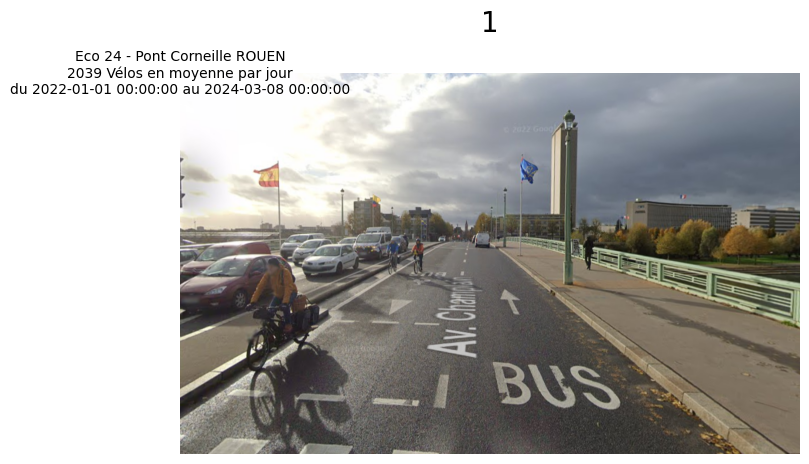

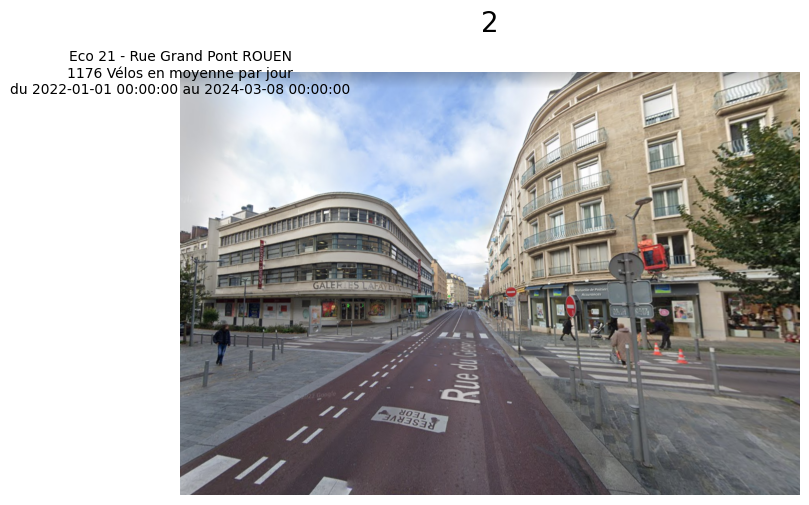

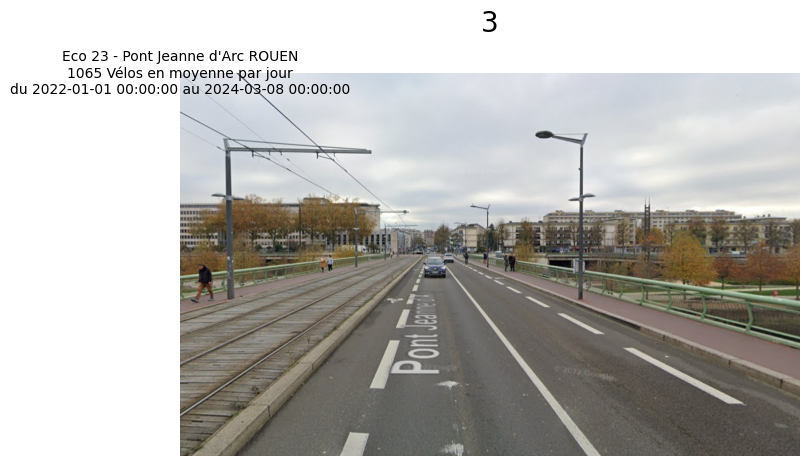

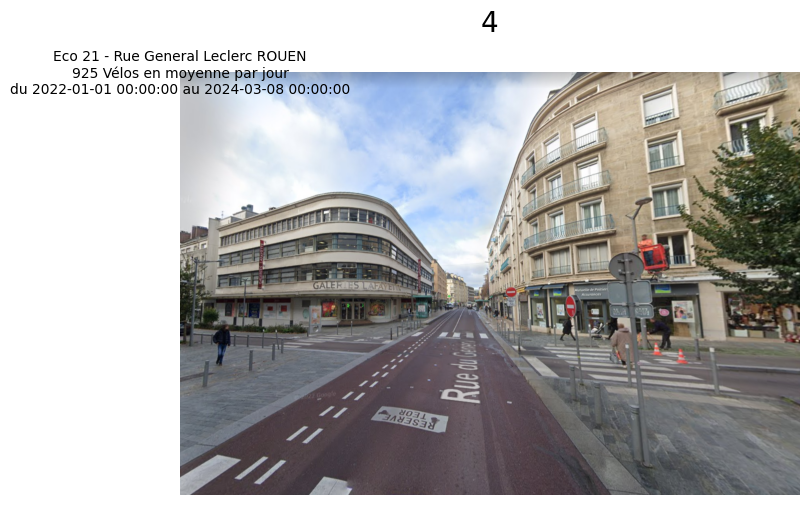

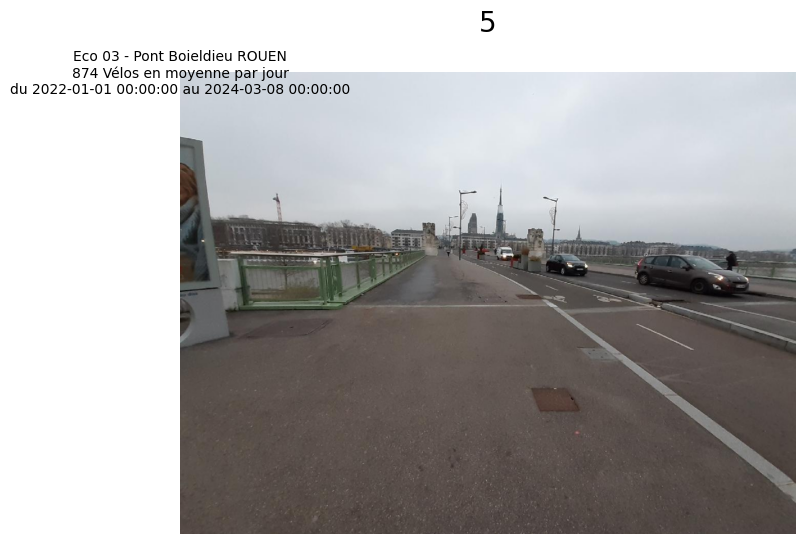

In [11]:
from PIL import Image, ImageDraw
from io import BytesIO
# Calculer le nombre total moyen de passages par jour pour chaque station
station_stats = df.groupby(['id', 'name', 'photourl']).agg(total_passages=('counts', 'sum'), total_days=('date_j', 'nunique')).reset_index()
station_stats['average_passages_per_day'] = station_stats['total_passages'] / station_stats['total_days']

# Classer les stations par le nombre total moyen de passages par jour de manière décroissante
top_stations = station_stats.sort_values(by='average_passages_per_day', ascending=False).head(5)

# Afficher les informations pour les cinq meilleures stations avec les images correspondantes depuis les liens dans 'photourl'
for i, (index, station) in enumerate(top_stations.iterrows(), 1):
    # Charger l'image depuis le lien correspondant à la station
    response = requests.get(station['photourl'])
    img = Image.open(BytesIO(response.content))

    # Afficher le numéro de la station et son image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'{i}\n', loc='center', fontsize=20)

    # Afficher les informations de la station
    plt.text(0.5, 0.5, f'{station["name"]}\n'
                        f'{int(station["average_passages_per_day"])} Vélos en moyenne par jour\n'
                        f'du {df["date_j"].min()} au {df["date_j"].max()}',
             ha='center', va='center', fontsize=10)

    # Masquer les axes
    plt.axis('off')

    # Afficher l'image
    plt.show()

In [12]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['Time'] = df['date']
df['Date'] = pd.to_datetime(df['date_j'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.day_of_week

# Convert 'Time' to datetime if it's not already
df['Time'] = pd.to_datetime(df['Time'])

# Extract the hour
df['Hour'] = df['Time'].dt.hour


In [13]:
from ipyleaflet import Map, CircleMarker
from IPython.display import display


# Ajout de la colonne 'Month-Year' à df
df['Month-Year'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)

# L'URL de l'API pour localisation des sites de comptage
api_url_localisation = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-sites/records?limit=29"
response_localisation = requests.get(api_url_localisation)

if response_localisation.status_code != 200:
    print(f'Échec de la requête HTTP, code de statut {response_localisation.status_code}')
    data_localisation = None
else:
    data_localisation = response_localisation.json()

# Création d'un DataFrame à partir des données de localisation
data_localisation_df = pd.DataFrame(data_localisation['results'])

# Fusion des DataFrames df et data_localisation_df sur la colonne 'name'
df_merged = pd.merge(df, data_localisation_df[['name', 'coordinates']], how='left', on='name')

# Création d'une liste de tous les mois de janvier 2022 à janvier 2024
months = df_merged['Month-Year'].unique()

# Création de la liste de dictionnaires
result_data = []
for mois in months:
    for nom in df_merged['name'].unique():
        # Filtrage des données pour le mois et le nom
        filtered_data = df_merged[(df_merged['name'] == nom) & (df_merged['Month-Year'] == mois)]
        # Calcul de la somme des valeurs de la colonne 'counts' pour ces données filtrées
        sum_count = filtered_data['counts'].sum()
        # Ajout des données à la liste de dictionnaires
        result_data.append({'mois': mois, 'name': nom, 'volume_month': sum_count})

# Création du DataFrame à partir de la liste de dictionnaires
df_result = pd.DataFrame(result_data)

def update_time(time):
    if data_localisation:
        map_center = [data_localisation['results'][0]['coordinates']['lat'], data_localisation['results'][0]['coordinates']['lon']]
        m = Map(center=map_center, zoom=10)
        
        if time in df_result['mois'].unique():
            max_volume = df_result['volume_month'].max()
            
            for record in data_localisation['results']:
                lon = record['coordinates']['lon']
                lat = record['coordinates']['lat']
                
                # Filtrage des données en fonction du temps
                filtered_data = df_result[(df_result['mois'] == time) & (df_result['name'] == record['name'])]
                volume = filtered_data['volume_month'].iloc[0] if not filtered_data.empty else 0
                
                # Calcul du rayon proportionnel au volume maximal
                scaled_radius = int(volume / max_volume * 50)  # 10 est le rayon maximal souhaité
                
                circle_marker = CircleMarker(location=(lat, lon), radius=scaled_radius, color="red", fill_color="red")
                m.add_layer(circle_marker)
        
        display(m)

# Créer un slider interactif pour sélectionner une plage de dates
dates = [(date.month, date.year) for date in pd.date_range(start='2022-04-01', end='2024-02-01', freq='M')]
date_strings = [f"{month}-{year}" for month, year in dates]

time_slider = widgets.SelectionSlider(options=date_strings, description='Time Range:', layout={'width': '500px'})

# Mettre à jour la carte en fonction de la valeur du curseur
widgets.interact(update_time, time=time_slider)


interactive(children=(SelectionSlider(description='Time Range:', layout=Layout(width='500px'), options=('4-202…

<function __main__.update_time(time)>

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

In [14]:
def plot(name):
    data = df.loc[df['name']==name,['Time','Date','counts','name']]
    return px.line(x=data['Time'],y=data['counts'],title=name,height=800)

widgets.interact(plot,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 06 - Rue de la Prevotiere BOIS GUILLAUME', "E…

<function __main__.plot(name)>

In [15]:
def plot_comptage_jour(name):
    data = df.loc[df['name']==name,['Date','counts']]
    data = data.groupby('Date').sum()
    data = data.reset_index()
    return px.line(x=data['Date'],y=data['counts'],title=name,height=500)

widgets.interact(plot_comptage_jour,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 06 - Rue de la Prevotiere BOIS GUILLAUME', "E…

<function __main__.plot_comptage_jour(name)>

In [16]:
def plot_comptage_jour_de_la_semaine(name):
    data = df.loc[df['name']==name,['DayOfWeek','counts']]
    data = data.groupby('DayOfWeek').mean()
    data = data.reset_index()
    return px.bar(x=data['DayOfWeek'],y=data['counts'],title=name,height=500)

widgets.interact(plot_comptage_jour_de_la_semaine,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 06 - Rue de la Prevotiere BOIS GUILLAUME', "E…

<function __main__.plot_comptage_jour_de_la_semaine(name)>

In [17]:
def plot_moyenne_horaire(name):
    data = df.loc[df['name']==name,['Hour','counts']]
    data = data.groupby('Hour').mean()
    data = data.reset_index()
    return px.bar(x=data['Hour'],y=data['counts'],title=name,height=500)

widgets.interact(plot_moyenne_horaire,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 06 - Rue de la Prevotiere BOIS GUILLAUME', "E…

<function __main__.plot_moyenne_horaire(name)>

In [18]:
def plot_volume_annuel(name):
    data = df.loc[df['name']==name,['Year','counts']]
    data = data.groupby('Year').sum()
    data = data.reset_index()
    return px.bar(x=data['Year'],y=data['counts'],title=name,height=500)

widgets.interact(plot_volume_annuel,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 06 - Rue de la Prevotiere BOIS GUILLAUME', "E…

<function __main__.plot_volume_annuel(name)>

In [19]:
def plot_volume_mensuel(name):
    data = df.loc[df['name']==name,['Month','Year','counts']]
    data = data.groupby(['Year','Month']).sum()
    data = data.reset_index()
    data['Month-Year'] = data['Month'].astype(str)+'-'+data['Year'].astype(str)
    return px.bar(x=data['Month-Year'],y=data['counts'],title=name,height=500)

widgets.interact(plot_volume_mensuel,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 06 - Rue de la Prevotiere BOIS GUILLAUME', "E…

<function __main__.plot_volume_mensuel(name)>

In [20]:
def multiplot(name):
    for f in plot(name),plot_comptage_jour(name),plot_comptage_jour_de_la_semaine(name),plot_moyenne_horaire(name),plot_volume_annuel(name),plot_volume_mensuel(name):
        f.show()

widgets.interact(multiplot,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 06 - Rue de la Prevotiere BOIS GUILLAUME', "E…

<function __main__.multiplot(name)>